- 补充
    - nodes correspond to states $s$
    - edges refer to actions $a$
        - each edge transfers the environment from its parent state to its child state
            - state transition
    - game tree
        - 交替落子 minimax setting；白子的 v（value） 是黑子的 -v；
            - 当前层黑子（边是黑子的action），下一层的为白子（边是白子的action）
            - 交替落子；
- 参考
    - https://github.com/brilee/python_uct
    - https://www.moderndescartes.com/essays/deep_dive_mcts/


In [1]:
import collections
import numpy as np
import math

## Node & search 

### Node

- 因为 simulate（rollout/evaluate）完了之后涉及到 bp（反向传播或者回溯），每个 node 除了需要指向 children，还需要维护 parent

In [2]:
name_id = 0

class UCTNode():
    def __init__(self, name, state, action, parent=None):
        self.name = name
        self.state = state
        self.action = action
        
        self.is_expanded = False
        
        # self.parent.child_total_value[self.action]
        # self.parent.child_number_visits[self.action]
        # 指向self
        self.parent = parent  # Optional[UCTNode]
        
        self.children = {}  # Dict[action, UCTNode]
        self.child_priors = np.zeros([10], dtype=np.float32)
        # ti
        self.child_total_value = np.zeros([10], dtype=np.float32)
        # ni
        self.child_number_visits = np.zeros([10], dtype=np.float32)
    
    
    # Ni
    @property
    def number_visits(self):
        return self.parent.child_number_visits[self.action]

    @number_visits.setter
    def number_visits(self, value):
        self.parent.child_number_visits[self.action] = value
        
    # ti
    @property
    def total_value(self):
        return self.parent.child_total_value[self.action]

    @total_value.setter
    def total_value(self, value):
        self.parent.child_total_value[self.action] = value

    # pUCT
    # https://courses.cs.washington.edu/courses/cse599i/18wi/resources/lecture19/lecture19.pdf
    def child_Q(self) -> np.ndarray:
        return self.child_total_value / (1 + self.child_number_visits)


    def child_U(self) -> np.ndarray:
        return math.sqrt(self.number_visits) * (
            self.child_priors / (1 + self.child_number_visits))
    
    
    def best_child(self) -> int:
        return np.argmax(self.child_Q() + self.child_U())
    
    # traversal
    def select_leaf(self):
        current = self
        while current.is_expanded:
            best_action = current.best_child()
            current = current.maybe_add_child(best_action)
        return current

    def expand(self, child_priors):
        self.is_expanded = True
        self.child_priors = child_priors

    def maybe_add_child(self, action):
        global name_id
        if action not in self.children:
            # 新增 child 节点时，切换 player 身份（白子 => 黑子，黑子 => 白子）
            name_id += 1
            self.children[action] = UCTNode(
                name_id, self.state.play(action), action, parent=self)
        return self.children[action]

    def backup(self, value_estimate: float):
        current = self
        while current.parent is not None:
            current.number_visits += 1
            current.total_value += (value_estimate * self.state.to_play)
            current = current.parent

### Q + U

$$
\begin{split}
&Q=\frac{t_i}{1+n_i}\\
&U=\sqrt{\ln N_i}\times \frac{P}{1+n_i}
\end{split}
$$

## Game state

In [3]:
# 交替落子 minimax setting；白子的 v（value） 是黑子的 -v；
class GameState:
    def __init__(self, to_play=1):
        self.to_play = to_play
    def play(self, action):
        return GameState(to_play=-self.to_play)

## Policy network & Value network

- 结合使用策略网络（Policy network）来指导搜索方向, 并使用价值网络来评估棋局的潜在价值, 可以显著减少搜索树的大小，提高搜索的效率。
    - 策略网络（Policy network）能够从先前的对局中学习到有效的走棋模式和策略，这相当于在搜索过程中加入了大量的“先验知识”（child_priors）。
- 价值网络（value network）可以给出对当前棋局胜负的直接评估，而不需要到达游戏的终局。这种评估能力对于减少搜索深度、加速决策过程至关重要。

In [4]:
class NeuralNet():
    @classmethod
    def evaluate(self, game_state):
        # return policy_network(state), value_network(state)
        # policy_network(state): return pi(a|s)
        # value_network(state): return v(s)
        return np.random.random([10]), np.random.random()

## UCT_search

In [5]:
class DummyNode(object):
    def __init__(self):
        self.parent = None
        self.child_total_value = collections.defaultdict(float)
        self.child_number_visits = collections.defaultdict(float)

In [6]:
def print_tree_level_width(root: UCTNode):
    if not root:
        return
    
    queue = [(root, 0)]  # 初始化队列，元素为 (节点, 层级)
    current_level = 0
    level_nodes = []

    while queue:
        node, level = queue.pop(0)  # 从队列中取出当前节点和它的层级
        # 当进入新的一层时，打印上一层的信息并重置
        if level > current_level:
            print(f"Level {current_level} width: {len(level_nodes)}")
            level_nodes = [f'{node.action}']  # 重置当前层的节点列表
            current_level = level
        else:
            level_nodes.append(f'{node.action}')
        
        # 将当前节点的所有子节点加入队列
        for child in node.children.values():
            queue.append((child, level + 1))
    
    # 打印最后一层的信息
    print(f"Level {current_level} width: {len(level_nodes)}")

In [7]:
def UCT_search(state, num_reads):
    root = UCTNode(0, state, action=None, parent=DummyNode())
    for _ in range(num_reads):
        # 每次都是从根节点出发
        leaf = root.select_leaf()
        # child_priors: [0, 1]
        child_priors, value_estimate = NeuralNet().evaluate(leaf.state)
        leaf.expand(child_priors)
        leaf.backup(value_estimate)
    print_tree_level_width(root)
    return root, root.best_child()

In [8]:
num_reads = 15
import time
tick = time.time()
root, _ = UCT_search(GameState(), num_reads)
tock = time.time()
print("Took %s sec to run %s times" % (tock - tick, num_reads))
import resource
print("Consumed %sB memory" % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

Level 0 width: 1
Level 1 width: 8
Level 2 width: 6
Took 0.004031181335449219 sec to run 15 times
Consumed 98188B memory


In [9]:
# !pip install igraph

In [10]:
import igraph as ig
g = ig.Graph(directed=True)

# 用于跟踪已添加节点的字典
nodes_dict = {}

def add_nodes_and_edges(node, parent_id=None):
    # 添加当前节点（如果尚未添加）
    if node not in nodes_dict:
        nodes_dict[node.name] = len(nodes_dict)
        g.add_vertices(1)
    
    current_id = nodes_dict[node.name]
    
    # 添加从父节点到当前节点的边
    if parent_id is not None:
        g.add_edges([(parent_id, current_id)])
    
    # 递归为子节点做同样的处理
    for child in node.children.values():
        add_nodes_and_edges(child, current_id)

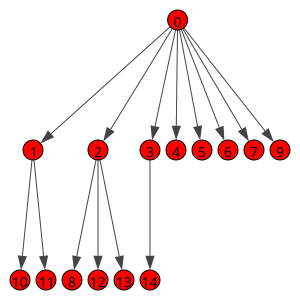

In [11]:
# 从根节点开始添加节点和边
add_nodes_and_edges(root)
layout = g.layout("tree", root=[0])

# 设置节点名称
g.vs["label"] = list(nodes_dict.keys())

# 可视化
ig.plot(g, layout=layout, bbox=(300, 300), margin=20)

## tic-tac-toe

- https://pastebin.com/bUcRrKwF
    - https://www.youtube.com/watch?v=gvlO_-Fdk9w